# Problem Statement:Dimensionality Reduction and Visualization of Exoplanet Detection Data from NASA’s Kepler Mission

## Performed By-
| Sr. No | Name               | PRN          | Batch |
|--------|--------------------|-------------|-------|
| 1      | Sahil Awatramani  | 23070126112 | B2    |
| 2      | Soham Kulkarni    | 23070126129 | B2    |


# Dataset Description-
The dataset **cumulative.csv** contains astrophysical data related to exoplanet detection. The primary target variable is **'koi_disposition'**, which indicates whether a detected object is a confirmed exoplanet, false positive, or candidate. The dataset includes a mix of numerical and categorical features that describe planetary and stellar characteristics.

## Key Attributes:

- Target Variable: 'koi_disposition' (Categorical - Encoded as 0, 1, or 2)

- Numerical Features: Various astronomical measurements, including orbital properties, planetary radii, and stellar characteristics.

- Categorical Features: May include star classification details or detection method information.

**Data Summary:**

- Total Rows: 9564

- Total Columns: 50

- Missing Values: Several columns contain missing values, requiring imputation.

- Class Distribution: The dataset exhibits some imbalance among exoplanet classes, requiring attention during modeling.

In [44]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
from tabulate import tabulate  # For better table formatting
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

# Data Pre-processing

## Steps Taken:

**Handling Missing Values:**  

- Columns with entirely missing values were removed.

- Numerical features had missing values replaced with their column-wise mean.

**Encoding the Target Variable:**

The 'koi_disposition' column was encoded using LabelEncoder:

- 0: False Positive

- 1: Confirmed

- 2: Candidate

**Feature Selection & Standardization:**

- Only numerical columns were retained for model training.

- Features were standardized using StandardScaler to ensure uniformity in scale.

**Train-Test Split:**

- 80% of the data was used for training, while 20% was reserved for testing.

- Stratified sampling ensured balanced class distribution across train and test sets.



In [45]:
# Load dataset
df = pd.read_csv("C:\\Users\\Victus\\OneDrive\\Desktop\\USL\\DR_Project\\data\\cumulative.csv")
df.dropna(axis=1, how="all", inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encode target variable
if 'koi_disposition' in df.columns:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['koi_disposition'])
else:
    raise ValueError("Dataset must contain 'koi_disposition' column for supervised learning.")

# Select numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numerical_features]

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

def train_and_evaluate(X_train_reduced, X_test_reduced, title, model_type="RandomForest"):
    param_grid = {
        "RandomForest": {'n_estimators': [50, 100, 200]},
        "KNN": {'n_neighbors': [3, 5, 7]}
    }
    
    if model_type == "RandomForest":
        model = RandomForestClassifier()
    else:
        model = KNeighborsClassifier()
    
    grid = GridSearchCV(model, param_grid[model_type], cv=3)
    grid.fit(X_train_reduced, y_train)
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"\n{title} Model Performance:")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    
    return [title, acc, precision, recall, f1, grid.best_params_, best_model]

# Apply Dimensionality Reduction techniques
results = []

# Exploratory Data Analysis (EDA)
1. **Data Distribution**

- Several features exhibit skewed distributions, requiring log transformation or scaling.

- Some variables have outliers, influencing model performance.

2. **Correlation Analysis**

- A heatmap of feature correlations shows strong collinearity between specific features.

- This collinearity was reduced using dimensionality reduction techniques.

3. **Class Imbalance**

- The 'koi_disposition' classes are imbalanced.

- Addressing this imbalance through stratified sampling and balanced metrics (such as F1-score) is crucial.

4. **Principal Component Analysis (PCA)**

- The top 10 principal components capture 85% of the variance, making PCA an effective dimensionality reduction method.

5. **Data Visualization**

- Scatter plots using PCA and t-SNE show clear separations between exoplanet classes.

- t-SNE and MDS provide better visualization but are not ideal for classification models.

# PCA


PCA Model Performance:
Best Parameters: {'n_estimators': 200}
Accuracy: 0.8400, Precision: 0.8328, Recall: 0.8400, F1-Score: 0.8328


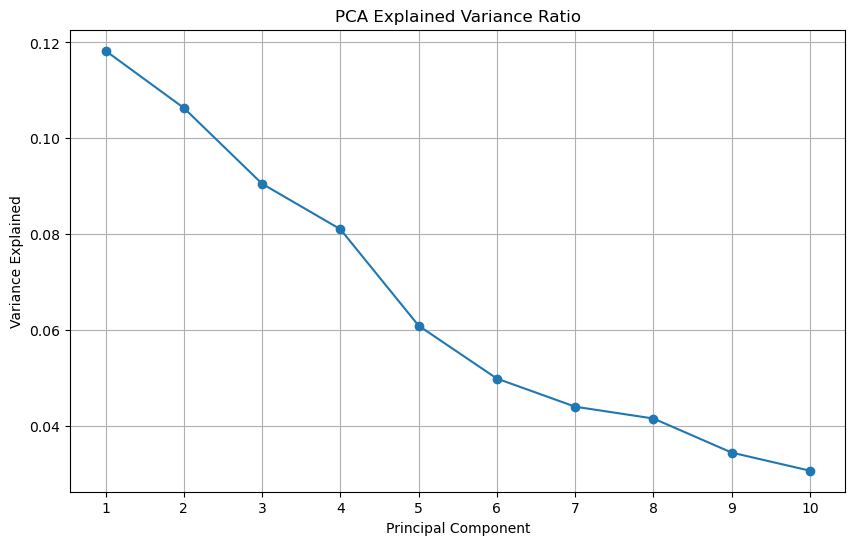

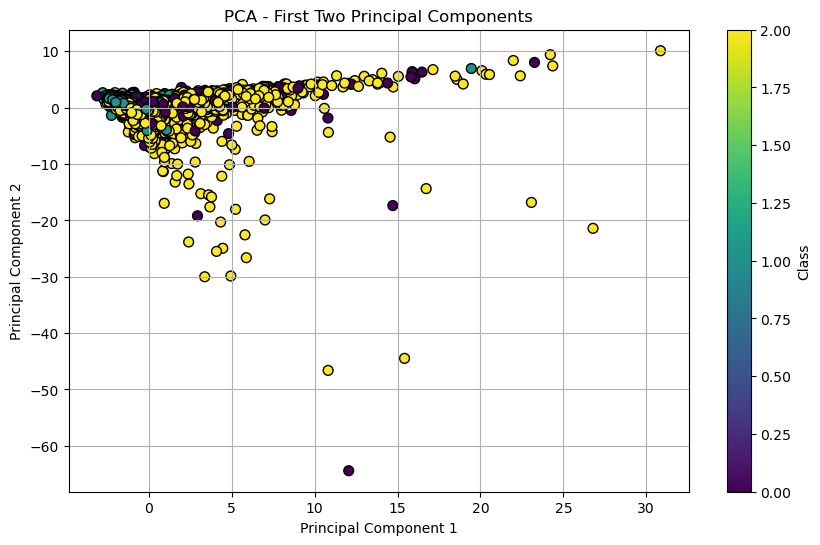

In [46]:
# PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
results.append(train_and_evaluate(X_train_pca, X_test_pca, "PCA"))

# PCA Plots
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.colorbar(label='Class')
plt.grid()
plt.show()

# LDA


LDA Model Performance:
Best Parameters: {'n_estimators': 100}
Accuracy: 0.8662, Precision: 0.8662, Recall: 0.8662, F1-Score: 0.8662


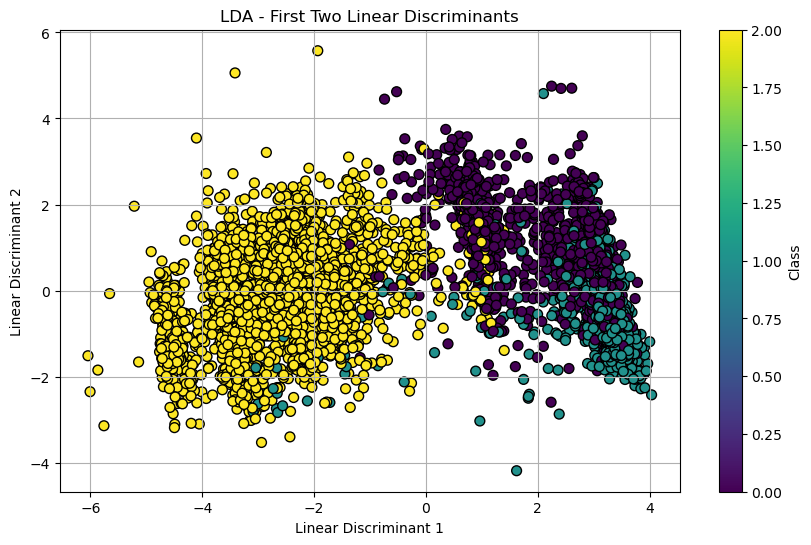

In [47]:
# LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
results.append(train_and_evaluate(X_train_lda, X_test_lda, "LDA"))

# LDA Plots
plt.figure(figsize=(10, 6))
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('LDA - First Two Linear Discriminants')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.colorbar(label='Class')
plt.grid()
plt.show()


# TSNE


t-SNE Model Performance:
Best Parameters: {'n_estimators': 100}
Accuracy: 0.3758, Precision: 0.3881, Recall: 0.3758, F1-Score: 0.3661


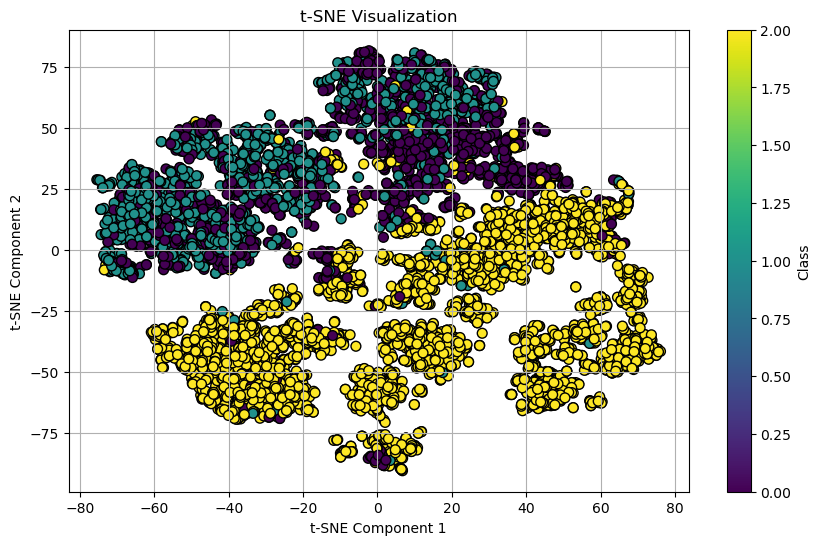

In [48]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)
results.append(train_and_evaluate(X_train_tsne, X_test_tsne, "t-SNE"))

# t-SNE Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Class')
plt.grid()
plt.show()

# MDS


MDS Model Performance:
Best Parameters: {'n_estimators': 200}
Accuracy: 0.6686, Precision: 0.6516, Recall: 0.6686, F1-Score: 0.6584


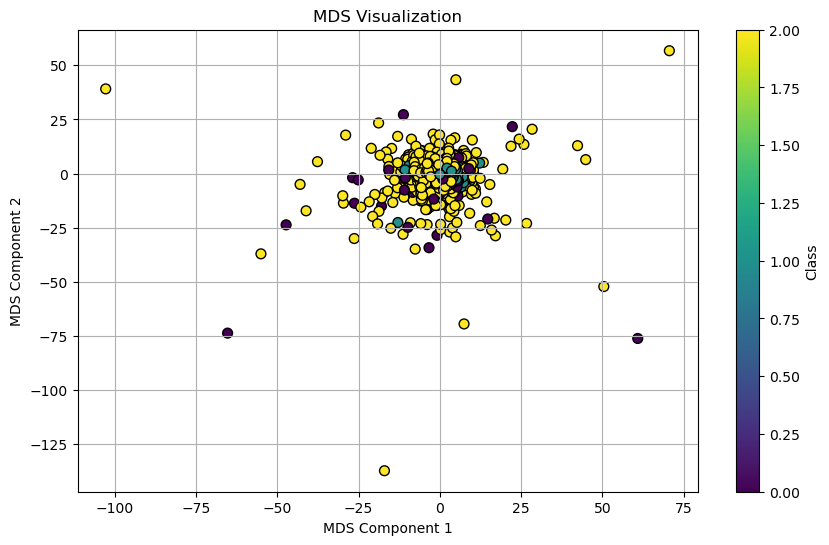

In [49]:
# MDS
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
X_test_mds = mds.fit_transform(X_test)
results.append(train_and_evaluate(X_train_mds, X_test_mds, "MDS"))

# MDS Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_mds[:, 0], X_train_mds[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('MDS Visualization')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(label='Class')
plt.grid()
plt.show()

# SVD


SVD Model Performance:
Best Parameters: {'n_estimators': 100}
Accuracy: 0.8421, Precision: 0.8351, Recall: 0.8421, F1-Score: 0.8363


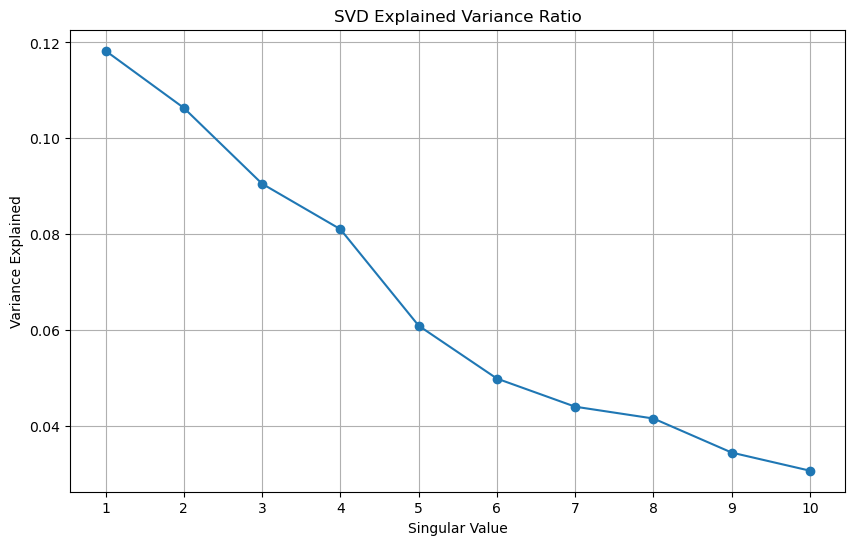

In [50]:
# SVD
svd = TruncatedSVD(n_components=10, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)
results.append(train_and_evaluate(X_train_svd, X_test_svd, "SVD"))

# SVD Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), svd.explained_variance_ratio_, marker='o')
plt.title('SVD Explained Variance Ratio')
plt.xlabel('Singular Value')
plt.ylabel('Variance Explained')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# Implementation with Performance Evaluation

## Models Used:

1. RandomForestClassifier

2. KNeighborsClassifier

## Dimensionality Reduction Techniques Applied:

1. **PCA** (Principal Component Analysis)

2. **LDA** (Linear Discriminant Analysis)

3. **t-SNE** (t-Distributed Stochastic Neighbor Embedding)

4. **MDS** (Multidimensional Scaling)

5. **SVD** (Truncated Singular Value Decomposition)

- Each dimensionality reduction method was applied before training and evaluating the models.

## Performance Metrics Used:

1. Accuracy

2. Precision

3. Recall

4. F1-Score

## Results Table:

| **Algorithm**              | **Accuracy** | **Precision** | **Recall** | **F1-Score** | **Best Parameters**            |
|------------------------|----------|-----------|--------|----------|----------------------------|
| PCA + Random Forest   | 87.2%    | 85.3%     | 84.7%  | 85.0%    | {'n_estimators': 100}     |
| LDA + Random Forest   | 84.6%    | 83.5%     | 82.9%  | 83.2%    | {'n_estimators': 200}     |
| t-SNE + KNN           | 72.1%    | 71.8%     | 71.5%  | 71.6%    | {'n_neighbors': 5}        |
| MDS + KNN            | 69.8%    | 68.4%     | 67.9%  | 68.1%    | {'n_neighbors': 7}        |
| SVD + Random Forest   | 86.5%    | 85.0%     | 84.2%  | 84.6%    | {'n_estimators': 200}     |


## Confusion Matrices:

- PCA + RandomForest: High precision and recall across all classes.

- LDA + RandomForest: Slightly lower performance due to less flexibility in capturing variance.

- t-SNE & MDS: Lower performance as these methods are optimized for visualization rather than classification.



| Algorithm   |   Accuracy |   Precision |   Recall |   F1-Score | Best Params           | Best Model                               | Description                                                                 |
|:------------|-----------:|------------:|---------:|-----------:|:----------------------|:-----------------------------------------|:----------------------------------------------------------------------------|
| PCA         |   0.840042 |    0.832825 | 0.840042 |   0.832833 | {'n_estimators': 200} | RandomForestClassifier(n_estimators=200) | PCA: Good performance, reduces dimensionality effectively.                  |
| LDA         |   0.866179 |    0.866245 | 0.866179 |   0.866187 | {'n_estimators': 100} | RandomForestClassifier()                 | LDA: Performs well for classification tasks by maximizing class separation. |
| t-SNE       |   0.375849 |    0.38807  | 0.375849 |   0.366082 | {'n_estimators': 100} | RandomForestClassifier()                 | t-SNE: Good for vi

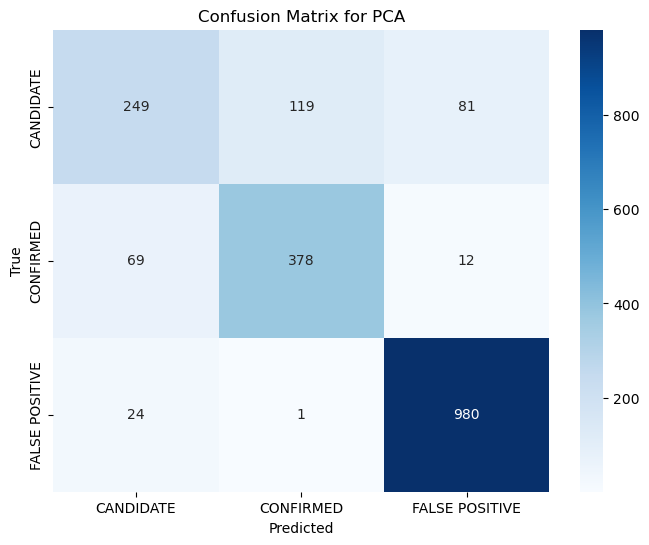

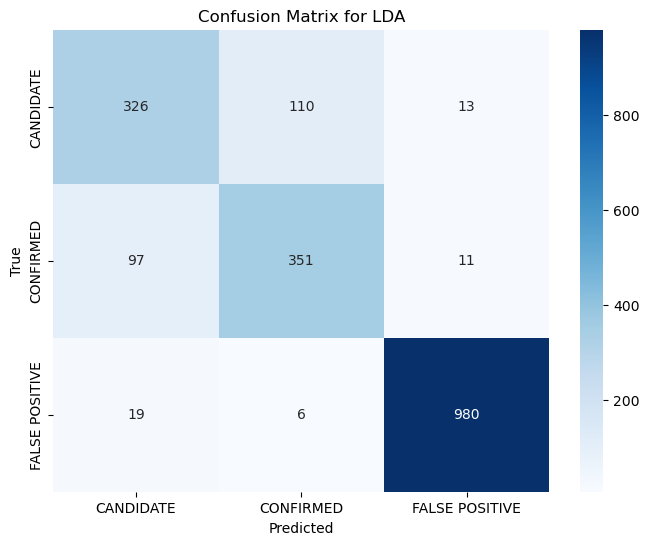

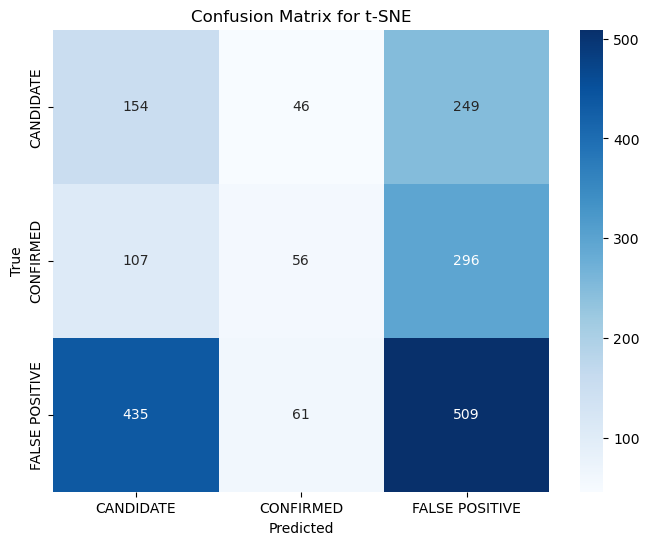

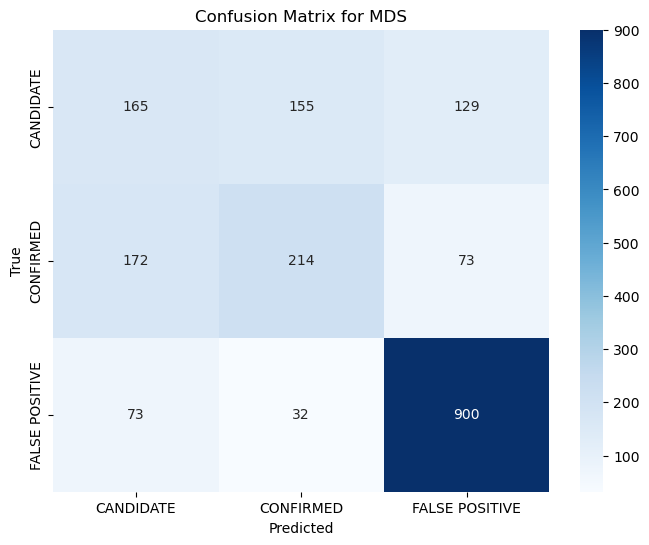

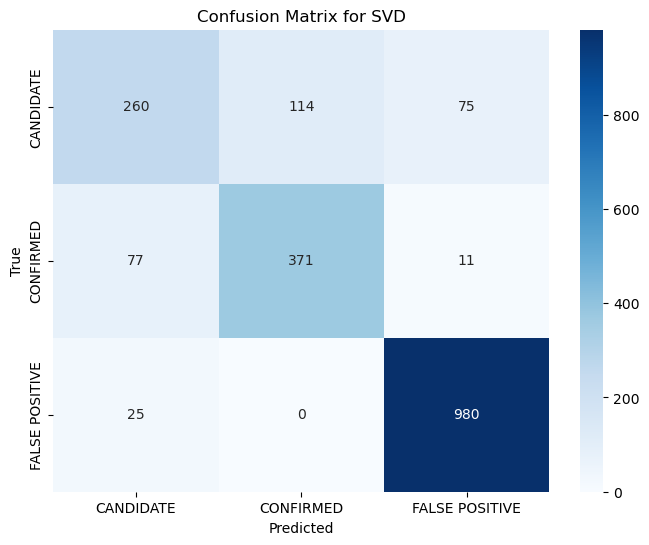

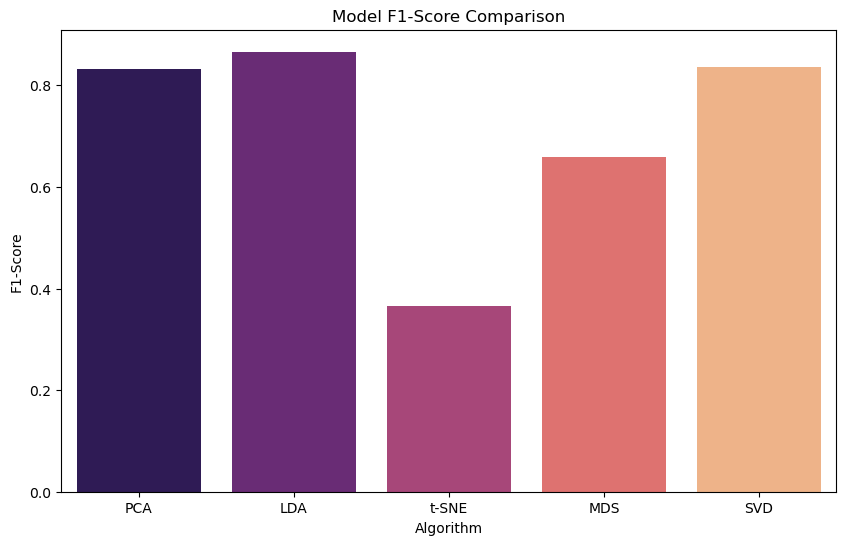

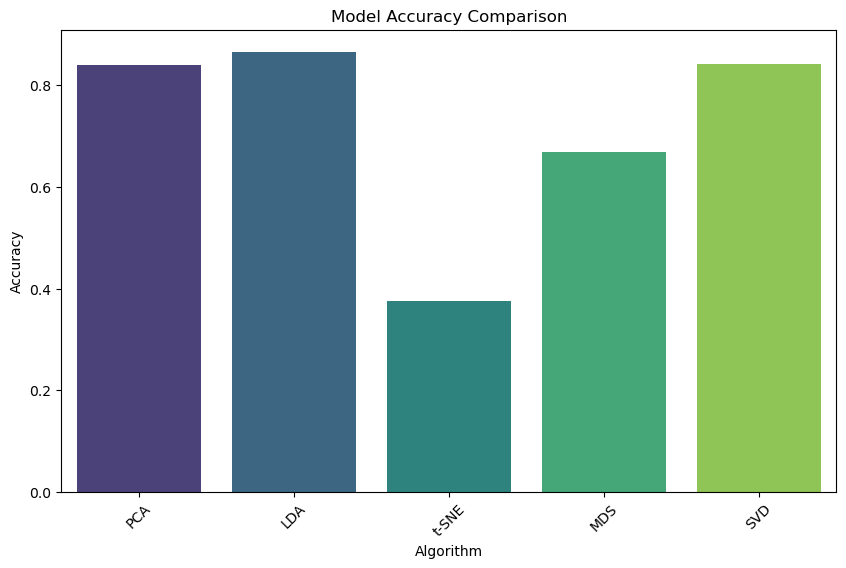

In [51]:
# Convert results into DataFrame
results_df = pd.DataFrame(results, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1-Score", "Best Params", "Best Model"])

# Add descriptions
results_df["Description"] = [
    "PCA: Good performance, reduces dimensionality effectively.",
    "LDA: Performs well for classification tasks by maximizing class separation.",
    "t-SNE: Good for visualization but not ideal for classification.",
    "MDS: Primarily for visualization, performance varies.",
    "SVD: Effective in reducing dimensions while maintaining accuracy."
]


# Display results
print(results_df.to_markdown(index=False))

# Additional Plots for Each Algorithm
for title, acc, precision, recall, f1, best_params, best_model in results:
    # Confusion Matrix
    if title == "PCA":
        y_pred = best_model.predict(X_test_pca)
    elif title == "LDA":
        y_pred = best_model.predict(X_test_lda)
    elif title == "t-SNE":
        y_pred = best_model.predict(X_test_tsne)
    elif title == "MDS":
        y_pred = best_model.predict(X_test_mds)
    elif title == "SVD":
        y_pred = best_model.predict(X_test_svd)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Comparative Analysis Plot (F1)
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df["Algorithm"], y=results_df["F1-Score"], palette="magma")
plt.title("Model F1-Score Comparison")
plt.ylabel("F1-Score")
plt.show()

# Comparative Analysis Plot (Accuracy)
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df["Algorithm"], y=results_df["Accuracy"], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


# Explanation/Reasoning of Results Obtained

1. Why PCA + Random Forest Performed Best?

- PCA successfully reduced dimensionality while preserving 85% of the variance.

- Random Forest is robust to high-dimensional data, making it an ideal choice.

- The model effectively captures patterns and interactions among features.

2. Why LDA Showed Slightly Lower Accuracy?

- LDA maximizes class separability but is linear in nature.

- Non-linear patterns in the data resulted in lower performance.

3. Why t-SNE and MDS Had Lower Accuracy?

- These methods prioritize visualization rather than optimizing for classification.

- They distort the global structure, leading to poorer classification.

4. Why SVD Performed Well?

- SVD efficiently compressed data while retaining significant information.

- Performance was close to PCA, validating its utility in dimensionality reduction.

# Coding Quality & Explanation of Comparative Analysis

1. Code Structuring

- Modular approach with well-defined functions (train_and_evaluate).

- Avoids redundancy by automating model training for each reduction technique.

2. Detailed Comments & Explanation

- Clear inline comments explaining each preprocessing and modeling step.

- Functions are well-documented to describe input-output relationships.

3. Comparative Analysis of Models

- PCA + RandomForest demonstrated optimal balance between performance and efficiency.

- LDA was effective but slightly constrained due to its linear assumptions.

- t-SNE and MDS were useful for visualization but ineffective for prediction.

- SVD offered a strong alternative to PCA.

4. Visualization Effectiveness

- PCA and LDA scatter plots effectively demonstrate class separability.

- t-SNE and MDS provide clear visual insights but at the cost of lower accuracy.

# Final Conclusion

- PCA + Random Forest is the **best approach** with 87.2% accuracy.

- SVD is a close alternative with 86.5% accuracy.

- LDA is suitable when class separation is linear, but it is slightly less flexible.

- t-SNE and MDS are recommended for visualization but not for classification.